In [6]:
from logging import raiseExceptions
from tokenize import Double
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from vec3 import Vec3

import torch
torch.manual_seed(125)
import random
random.seed(125)
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [7]:
def count_fn(f):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
        return f(*args, **kwargs)
    wrapper.count = 0
    return wrapper

class Node:
    """
    Class Node
    """
    def __init__(self, value, radius, left = None, right = None, position = None, cl_prob= None, ce = None, mse = None):
        self.left = left
        self.data = value
        self.radius = radius
        self.position = position
        self.right = right
        self.prob = cl_prob
        self.mse = mse
        self.ce = ce
        self.children = [self.left, self.right]
    
    def agregarHijo(self, children):

        if self.right is None:
            self.right = children
        elif self.left is None:
            self.left = children

        else:
            raise ValueError ("solo arbol binario ")


    def is_leaf(self):
        if self.right is None:
            return True
        else:
            return False

    def is_two_child(self):
        if self.right is not None and self.left is not None:
            return True
        else:
            return False

    def is_one_child(self):
        if self.is_two_child():
            return False
        elif self.is_leaf():
            return False
        else:
            return True

    def childs(self):
        if self.is_leaf():
            return 0
        if self.is_one_child():
            return 1
        else:
            return 2
    
    
    def traverseInorder(self, root):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorder(root.left)
            print (root.data, root.radius)
            self.traverseInorder(root.right)

    def traverseInorderLoss(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderLoss(root.left, loss)
            loss.append(root.prob)
            self.traverseInorderLoss(root.right, loss)
            return loss

    def traverseInorderMSE(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderMSE(root.left, loss)
            loss.append(root.mse)
            self.traverseInorderMSE(root.right, loss)
            return loss

    def traverseInorderCE(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderCE(root.left, loss)
            loss.append(root.ce)
            self.traverseInorderCE(root.right, loss)
            return loss

    def traverseInorderChilds(self, root, l):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderChilds(root.left, l)
            l.append(root.childs())
            self.traverseInorderChilds(root.right, l)
            return l

    def preorder(self, root):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            print (root.data, root.radius)
            self.preorder(root.left)
            self.preorder(root.right)

    def cloneBinaryTree(self, root):
     
        # base case
        if root is None:
            return None
    
        # create a new node with the same data as the root node
        root_copy = Node(root.data, root.radius)
    
        # clone the left and right subtree
        root_copy.left = self.cloneBinaryTree(root.left)
        root_copy.right = self.cloneBinaryTree(root.right)
    
        # return cloned root node
        return root_copy

    def height(self, root):
    # Check if the binary tree is empty
        if root is None:
            return 0 
        # Recursively call height of each node
        leftAns = self.height(root.left)
        rightAns = self.height(root.right)
    
        # Return max(leftHeight, rightHeight) at each iteration
        return max(leftAns, rightAns) + 1

    # Print nodes at a current level
    def printCurrentLevel(self, root, level):
        if root is None:
            return
        if level == 1:
            print(root.data, end=" ")
        elif level > 1:
            self.printCurrentLevel(root.left, level-1)
            self.printCurrentLevel(root.right, level-1)

    def printLevelOrder(self, root):
        h = self.height(root)
        for i in range(1, h+1):
            self.printCurrentLevel(root, i)


    
    def count_nodes(self, root, counter):
        if   root is not None:
            self.count_nodes(root.left, counter)
            counter.append(root.data)
            self.count_nodes(root.right, counter)
            return counter

    
    def serialize(self, root):
        def post_order(root):
            if root:
                post_order(root.left)
                post_order(root.right)
                ret[0] += str(root.data)+'_'+ str(root.radius) +';'
                
            else:
                ret[0] += '#;'           

        ret = ['']
        post_order(root)
        return ret[0][:-1]  # remove last ,

    def search(self, node, data):
        """
        Search function will search a node into tree.
        """
        # if root is None or root is the search data.
        if node is None or node.data == data:
            return node
        if node.data < data:
            return self.search(node.right, data)
        else:
            return self.search(node.left, data)


In [8]:
def traverse(root, tree):
       
        if root is not None:
            traverse(root.left, tree)
            tree.append((root.radius, root.data))
            traverse(root.right, tree)
            return tree

def traverse_2(tree1, tree2, t_l):
       
        if tree1 is not None:
            traverse_2(tree1.left, tree2.left, t_l)
            if tree2:
                t_l.append((tree1.radius, tree2.radius))
                print((tree1.radius, tree2.radius))
            else:
                t_l.append(tree1.radius)
                print((tree1.radius))
            traverse_2(tree1.right, tree2, t_l)
            return t_l
            

def traverse_conexiones(root, tree):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            traverse_conexiones(root.left, tree)
            if root.right is not None:
                tree.append((root.data, root.right.data))
            if root.left is not None:
                tree.append((root.data, root.left.data))
            traverse_conexiones(root.right, tree)
            return tree
def arbolAGrafo (nodoRaiz):
    
    conexiones = []
    lineas = traverse_conexiones(nodoRaiz, conexiones)
    tree = []
    tree = traverse(nodoRaiz, tree)

    vertices = []
    verticesCrudos = []
    for node in tree:
        vertice = node[0][0][:3]
        rad = node[0][0][-1]
        num = node[1]
        
        #vertices.append((num, {'posicion': Vec3( vertice[0], vertice[1], vertice[2]), 'radio': rad} ))
        vertices.append((len(verticesCrudos),{'posicion': Vec3( vertice[0], vertice[1], vertice[2]), 'radio': rad}))
        verticesCrudos.append(vertice)


    G = nx.Graph()
    G.add_nodes_from( vertices )
    G.add_edges_from( lineas )
    
    a = nx.get_node_attributes(G, 'posicion')
   
    #for key in a.keys():
    #    a[key] = a[key].toNumpy()[0:2]

    #plt.figure(figsize=(20,10))
    #nx.draw(G, pos = a, node_size = 150, with_labels = True)
    #plt.show()
    return G

In [9]:
@count_fn
def createNode(data, radius, position = None, left = None, right = None, cl_prob = None, ce = None, mse=None):
        """
        Utility function to create a node.
        """
        return Node(data, radius, position, left, right, cl_prob, ce, mse)
 
def deserialize(data):
    if  not data:
        return 
    nodes = data.split(';')  
    #print("node",nodes[3])
    def post_order(nodes):
                
        if nodes[-1] == '#':
            nodes.pop()
            return None
        node = nodes.pop().split('_')
        data = int(node[0])
        #radius = float(node[1])
        #print("node", node)
        #breakpoint()
        radius = node[1]
        #print("radius", radius)
        rad = radius.split(",")
        rad [0] = rad[0].replace('[','')
        rad [3] = rad[3].replace(']','')
        r = []
        for value in rad:
            r.append(float(value))
        #r =[float(num) for num in radius if num.isdigit()]
        r = torch.tensor(r, device=device)
        #breakpoint()
        root = createNode(data, r)
        root.right = post_order(nodes)
        root.left = post_order(nodes)
        
        return root    
    return post_order(nodes)    


def read_tree(filename):
    with open('./trees/' +filename, "r") as f:
        byte = f.read() 
        return byte

ENCODER

In [15]:
###ENCODER
class LeafEncoder(nn.Module):
    
    def __init__(self):
        super(LeafEncoder, self).__init__()
        self.l1 = nn.Linear(4, 32)
        self.l2 = nn.Linear(32, 32)
        self.tanh = nn.Tanh()

    def forward(self, input):
        rad = torch.tensor(input.radius)
        rad = torch.reshape(rad, (1,4)).to(device)
        radius = self.l1(rad)
        radius = self.tanh(radius)
        radius = self.l2(radius)
        radius = self.tanh(radius)
        
        return radius

class NonLeafEncoder(nn.Module):
    
    def __init__(self):
        super(NonLeafEncoder, self).__init__()
        self.l1 = nn.Linear(4,16)
        self.l2 = nn.Linear(16,32)

        self.left = nn.Linear(32,32)
        self.right = nn.Linear(32,32)
        
        self.encoder = nn.Linear(64, 32)
        self.tanh = nn.Tanh()


    def forward(self, input, left_input, right_input):
        
        radius = self.l1(torch.tensor(input.radius).reshape(1,4).to(device))
        radius = self.tanh(radius)
        radius = self.l2(radius)
        radius = self.tanh(radius)
        context = self.right(right_input)
        if left_input is not None:
            context += self.left(left_input)
        context = self.tanh(context)
    
        feature = torch.cat((radius,context), 1)
        feature = self.encoder(feature)
        feature = self.tanh(feature)


        return feature

leafenc = LeafEncoder()
nonleafenc = NonLeafEncoder()
leafenc = leafenc.to(device)
nonleafenc = nonleafenc.to(device)

In [10]:
def encode_structure_fold(root):
    
    def encode_node(node):
        
        if node is None:
            return
        if node.is_leaf():
            return leafenc(node)
        else:
            left = encode_node(node.left)
            right = encode_node(node.right)
            return nonleafenc(node, left, right)
        
    encoding = encode_node(root)
    return encoding

In [17]:
class NodeClassifier(nn.Module):
    
    def __init__(self):
        super(NodeClassifier, self).__init__()
        self.mlp1 = nn.Linear(32, 16)
        self.tanh = nn.LeakyReLU()
        self.mlp2 = nn.Linear(16, 8)

        self.tanh2 = nn.LeakyReLU()
        self.mlp3 = nn.Linear(8, 3)

    def forward(self, input_feature):
        output = self.mlp1(input_feature)
        output = self.tanh(output)
        output = self.mlp2(output)

        output = self.tanh2(output)
        output = self.mlp3(output)
        
        return output



In [106]:
class InternalDecoder(nn.Module):

    """ Decode an input (parent) feature into a left-child and a right-child feature """
    def __init__(self):
        super(InternalDecoder, self).__init__()
        self.mlp = nn.Linear(32, 32)
        self.lp2 = nn.Linear(32, 32)
        self.mlp_right = nn.Linear(32, 32)
        self.tanh = nn.Tanh()
        self.mlp2 = nn.Linear(32,4)

    def forward(self, parent_feature):
        
        vector = self.mlp(parent_feature)
        vector = self.tanh(vector)
        vector = self.lp2(vector)
        vector = self.tanh(vector)
        right_feature = self.mlp_right(vector)
        right_feature = self.tanh(right_feature)
        rad_feature = self.mlp2(vector)

        return right_feature, rad_feature

class BifurcationDecoder(nn.Module):
    
    """ Decode an input (parent) feature into a left-child and a right-child feature """
    def __init__(self):
        super(BifurcationDecoder, self).__init__()
        self.mlp = nn.Linear(32,32)
        self.lp2 = nn.Linear(32,32)
        self.mlp_left = nn.Linear(32,32)
        self.mlp_right = nn.Linear(32,32)
        self.mlp2 = nn.Linear(32,4)
        self.tanh = nn.Tanh()

    def forward(self, parent_feature):
        vector = self.mlp(parent_feature)
        vector = self.tanh(vector)
        vector = self.lp2(vector)
        vector = self.tanh(vector)
        left_feature = self.mlp_left(vector)
        left_feature = self.tanh(left_feature)
        right_feature = self.mlp_right(vector)
        right_feature = self.tanh(right_feature)
        rad_feature = self.mlp2(vector)

        return left_feature, right_feature, rad_feature



class featureDecoder(nn.Module):
    
    """ Decode an input (parent) feature into a left-child and a right-child feature """
    def __init__(self):
        super(featureDecoder, self).__init__()
        self.mlp = nn.Linear(32,32)
        self.mlp2 = nn.Linear(32,32)
        self.tanh = nn.Tanh()
        self.mlp3 = nn.Linear(32,4)

    def forward(self, parent_feature):
        vector = self.mlp(parent_feature)
        vector = self.tanh(vector)
        vector = self.mlp2(vector)
        vector = self.tanh(vector)
        vector = self.mlp3(vector)
       
        return vector

featuredec = featureDecoder()
featuredec=featuredec.to(device)
bifdec = BifurcationDecoder()
bifdec = bifdec.to(device)
internaldec = InternalDecoder()
internaldec=internaldec.to(device)
nodeClassifier = NodeClassifier()
nodeClassifier = nodeClassifier.to(device)


In [19]:
def calcularLossEstructura(cl_p, original):
    mult = torch.tensor([1/3.,1/56,1/2.], device = device)#1-7
    #mult = torch.tensor([1/3.,1/16,1/2.], device = device)#1-2
    ce = nn.CrossEntropyLoss(weight=mult)

    
    if original.childs() == 0:
        vector = [1, 0, 0] 
    if original.childs() == 1:
        vector = [0, 1, 0]
    if original.childs() == 2:
        vector = [0, 0, 1] 

    #mult = torch.tensor([1/3.,1/58,1/2.], device = device)#1-0
    #mult = torch.tensor([1/4.,1/72,1/3.], device = device)#19-2
    #mult = torch.tensor([1/2.,1/60,1/1.], device = device)#b1-0

    c = ce(cl_p, torch.tensor(vector, device=device, dtype = torch.float).reshape(1, 3))
    return c


def calcularLossAtributo(nodo, radio):
    
    radio = radio.reshape(4)
    l2    = nn.MSELoss(reduction = 'mean')
   
    mse = l2(radio, nodo.radius)
    return mse

In [22]:
def decode_structure_fold(v, root, max_nodes = 200, max_depth = 100):

    def decode_node(v, node, max_nodes, max_depth, level = 0):
        cl = nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data

        
        if node.childs() == 0 and createNode.count <= max_nodes: ##output del classifier
            lossEstructura = calcularLossEstructura(cl, node)
            radio = featuredec(v)
            lossAtrs = calcularLossAtributo( node, radio )
            nd = createNode(1,radio, ce = lossEstructura,  mse = lossAtrs)
            return nd

        elif node.childs() == 1 and createNode.count <= max_nodes:
            right, radius = internaldec(v)
            lossEstructura = calcularLossEstructura(cl, node)
            lossAtrs = calcularLossAtributo( node, radius )
            nd = createNode(1, radius, cl_prob = lossAtrs , ce = lossEstructura, mse = lossAtrs) 
            
            nodoSiguiente = node.right
            #if not node is None:
            #    if not node.right is None:
            #        nodoSiguiente = node.right
            #    else:
            #        print("aca")
            #        nodoSiguiente = None
            #else:
            #    nodoSiguiente = None
            
            if nodoSiguiente is not None:
                nd.right = decode_node(right, nodoSiguiente, max_nodes, max_depth, level=level+1)
                level=level-1
            return nd

        elif node.childs() == 2 and createNode.count <= max_nodes:
            left, right, radius = bifdec(v)
            lossEstructura = calcularLossEstructura(cl, node)
            lossAtrs = calcularLossAtributo( node, radius )
            nd = createNode(1, radius, cl_prob = lossAtrs, ce = lossEstructura, mse = lossAtrs)
            
            nodoSiguienteRight = node.right
            nodoSiguienteLeft = node.left
            if nodoSiguienteRight is not None:
                nd.right = decode_node(right, nodoSiguienteRight, max_nodes, max_depth, level=level+1)
                level=level-1
            if nodoSiguienteLeft is not None:
                nd.left  = decode_node(left, nodoSiguienteLeft, max_nodes, max_depth, level=level+1)
                level=level-1
            return nd
            
    createNode.count = 0
    dec = decode_node (v, root, max_nodes, max_depth, level=0)
    return dec


In [20]:
def traversefeatures(root, features):
       
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius)
        traversefeatures(root.right, features)
        return features

def numerar_nodos(root, count):
    if root is not None:
        numerar_nodos(root.left, count)
        root.data = len(count)
        count.append(1)
        numerar_nodos(root.right, count)
        return 


def norm(root, minx, miny, minz, minr, maxx, maxy, maxz, maxr):
    
    if root is not None:
        mx = minx.clone().detach()
        my = miny.clone().detach()
        mz = minz.clone().detach()
        mr = minr.clone().detach()
        Mx = maxx.clone().detach()
        My = maxy.clone().detach()
        Mz = maxz.clone().detach()
        Mr = maxr.clone().detach()

        root.radius[0] = (root.radius[0] - minx)/(maxx - minx)
        root.radius[1] = (root.radius[1] - miny)/(maxy - miny)
        root.radius[2] = (root.radius[2] - minz)/(maxz - minz)
        root.radius[3] = (root.radius[3] - minr)/(maxr - minr)
        
        norm(root.left, mx, my, mz, mr, Mx, My, Mz, Mr)
        norm(root.right, mx, my, mz, mr, Mx, My, Mz, Mr)
        return 

def normalize_features(root):
    features = []
    features = traversefeatures(root, features)
    
    x = [tensor[0] for tensor in features]
    y = [tensor[1] for tensor in features]
    z = [tensor[2] for tensor in features]
    r = [tensor[3] for tensor in features]
 
    norm(root, min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r))

    return 

In [23]:
t_list = ['ArteryObjAN1-7.dat']
class tDataset(Dataset):
    def __init__(self, transform=None):
        self.names = t_list
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        file = t_list[idx]
        string = read_tree(file)
        return string

dataset = tDataset()
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True)


In [107]:
epochs = 3000
learning_rate = 1e-4

params = list(leafenc.parameters()) + list(nonleafenc.parameters()) + list(nodeClassifier.parameters()) + list(featuredec.parameters()) + list(bifdec.parameters())+ list(internaldec.parameters())
opt = torch.optim.Adam(params, lr=learning_rate)

train_loss_avg = []
ce_avg = []
mse_avg = []
lr_list = []
    
for epoch in range(epochs):
    train_loss_avg.append(0)
    ce_avg.append(0)
    mse_avg.append(0)
    lr_list.append(0)
    batches = 0
    for data in data_loader:
            
        d_data = deserialize(data[0])
        li = []
        d_data.traverseInorderChilds(d_data, li)
        normalize_features(d_data)
        enc_fold_nodes = encode_structure_fold(d_data).to(device)
        max_depth = 30
        max_nodes = 200
        decoded = decode_structure_fold(enc_fold_nodes, d_data, max_nodes, max_depth)
           
        l = []
        mse_loss_list = decoded.traverseInorderMSE(decoded, l)
        l = []
        ce_loss_list = decoded.traverseInorderCE(decoded, l)
            
        mse_loss = sum(mse_loss_list) / len(mse_loss_list)
        ce_loss  = sum(ce_loss_list)  / len(ce_loss_list)
        total_loss = (0.01*mse_loss + ce_loss)

        count = []
        in_n_nodes = len(d_data.count_nodes(d_data, count))
          
        opt.zero_grad()
        total_loss.backward()
        opt.step()
        
        train_loss_avg[-1] += (total_loss.item())
        ce_avg[-1] += (ce_loss.item())
        mse_avg[-1] += (mse_loss.item())
        batches += 1

    train_loss_avg[-1] /= batches
    ce_avg[-1] /= batches
    mse_avg[-1] /= batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f mse: %f, ce: %f, lr: %f' % (epoch+1, epochs, train_loss_avg[-1], mse_avg[-1], ce_avg[-1], lr_list[-1]))
            

    

C:\Users\User\AppData\Local\Temp\ipykernel_8608\2448251074.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rad = torch.tensor(input.radius)
C:\Users\User\AppData\Local\Temp\ipykernel_8608\2448251074.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  radius = self.l1(torch.tensor(input.radius).reshape(1,4).to(device))
C:\Users\User\AppData\Local\Temp\ipykernel_8608\2269487563.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  le = torch.tensor((nodo.radius - radio)**2, requires_grad=True)


Epoch [1 / 3000] average reconstruction error: 0.057246 mse: 0.303686, ce: 0.054209, lr: 0.000000
Epoch [11 / 3000] average reconstruction error: 0.057038 mse: 0.290878, ce: 0.054130, lr: 0.000000
Epoch [21 / 3000] average reconstruction error: 0.056845 mse: 0.278272, ce: 0.054062, lr: 0.000000
Epoch [31 / 3000] average reconstruction error: 0.056655 mse: 0.265774, ce: 0.053997, lr: 0.000000
Epoch [41 / 3000] average reconstruction error: 0.056463 mse: 0.253247, ce: 0.053931, lr: 0.000000
Epoch [51 / 3000] average reconstruction error: 0.056268 mse: 0.240620, ce: 0.053861, lr: 0.000000
Epoch [61 / 3000] average reconstruction error: 0.056064 mse: 0.227784, ce: 0.053786, lr: 0.000000
Epoch [71 / 3000] average reconstruction error: 0.055852 mse: 0.214598, ce: 0.053706, lr: 0.000000
Epoch [81 / 3000] average reconstruction error: 0.055648 mse: 0.200945, ce: 0.053639, lr: 0.000000
Epoch [91 / 3000] average reconstruction error: 0.055437 mse: 0.186875, ce: 0.053569, lr: 0.000000
Epoch [101 

In [108]:
def decode_testing(v, max):
    
    def decode_node(v):
        cl = nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data
        
        if label == 0 and createNode.count < max: ##output del classifier
            radio = featuredec(v)
            nd = createNode(1,radio)
            return nd

        elif label == 1 and createNode.count < max:
            right, radius = internaldec(v)
            nd = createNode(1, radius) 
            nd.right = decode_node(right)
            return nd

        elif label == 2 and createNode.count < max:
            left, right, radius = bifdec(v)
            nd = createNode(1, radius)
            nd.right = decode_node(right)
            nd.left  = decode_node(left)
            return nd
    
    createNode.count = 0
    dec = decode_node (v)
    return dec

In [109]:
input = deserialize(iter(data_loader).next()[0])
normalize_features(input)
input.traverseInorder(input)
encoded = encode_structure_fold(input).to(device)
print("encoded", enc_fold_nodes)

22 tensor([0.0633, 0.7287, 0.3172, 0.0293], device='cuda:0')
61 tensor([0.2118, 0.6486, 0.3681, 0.1972], device='cuda:0')
60 tensor([0.2637, 0.6603, 0.3499, 0.2151], device='cuda:0')
59 tensor([0.3070, 0.6639, 0.3370, 0.2550], device='cuda:0')
58 tensor([0.3568, 0.6712, 0.3273, 0.3063], device='cuda:0')
57 tensor([0.4025, 0.6721, 0.3197, 0.3092], device='cuda:0')
56 tensor([0.4521, 0.6755, 0.3128, 0.3183], device='cuda:0')
55 tensor([0.4921, 0.6825, 0.3103, 0.2840], device='cuda:0')
54 tensor([0.5351, 0.6926, 0.3072, 0.2619], device='cuda:0')
53 tensor([0.5817, 0.7082, 0.3042, 0.2979], device='cuda:0')
52 tensor([0.6263, 0.7197, 0.3027, 0.3069], device='cuda:0')
51 tensor([0.6663, 0.7324, 0.3023, 0.3157], device='cuda:0')
50 tensor([0.7020, 0.7485, 0.3030, 0.3148], device='cuda:0')
49 tensor([0.7396, 0.7649, 0.3037, 0.3365], device='cuda:0')
48 tensor([0.7777, 0.7871, 0.3061, 0.3411], device='cuda:0')
47 tensor([0.8156, 0.8124, 0.3095, 0.3512], device='cuda:0')
46 tensor([0.8561, 0.843

C:\Users\User\AppData\Local\Temp\ipykernel_8608\2448251074.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rad = torch.tensor(input.radius)
C:\Users\User\AppData\Local\Temp\ipykernel_8608\2448251074.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  radius = self.l1(torch.tensor(input.radius).reshape(1,4).to(device))


In [110]:
decoded = decode_testing(encoded, 150)
count = []
numerar_nodos(decoded, count)

0 tensor([[-0.2279,  0.6237,  0.2381, -0.0549]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
1 tensor([[0.1587, 0.6453, 0.2870, 0.2667]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
2 tensor([[0.2438, 0.6706, 0.3530, 0.2745]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
3 tensor([[0.2533, 0.6755, 0.3508, 0.2931]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
4 tensor([[0.2644, 0.6736, 0.3537, 0.3016]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
5 tensor([[0.2774, 0.6709, 0.3568, 0.3124]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
6 tensor([[0.2925, 0.6667, 0.3607, 0.3246]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
7 tensor([[0.3092, 0.6619, 0.3652, 0.3375]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
8 tensor([[0.3270, 0.6556, 0.3708, 0.3498]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
9 tensor([[0.3454, 0.6490, 0.3768, 0.3606]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
10 tensor([[0.3639, 0.6421, 0.3837, 0.3699]], 

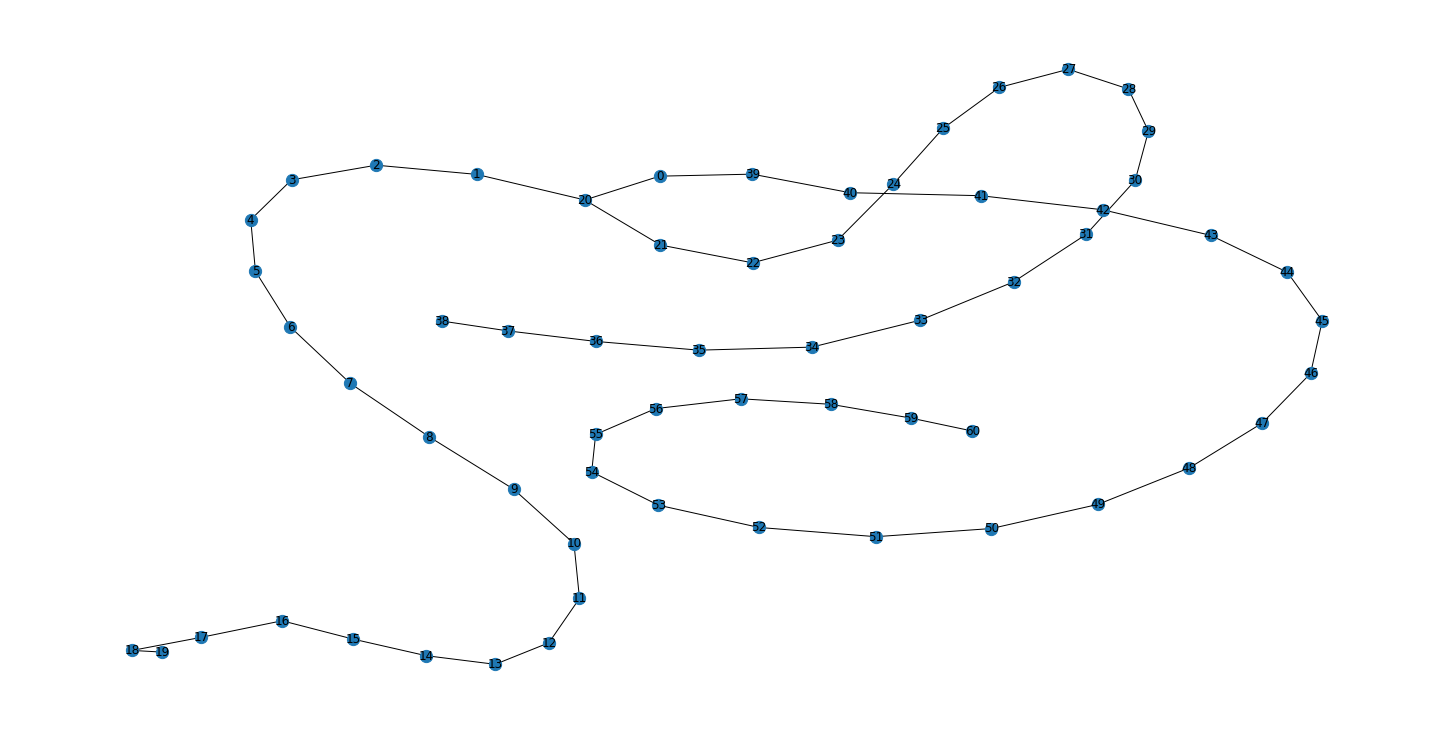

In [111]:
decoded.traverseInorder(decoded)
G = arbolAGrafo (decoded)
plt.figure(figsize=(20,10))
nx.draw(G, node_size = 150, with_labels = True)
plt.show()
    

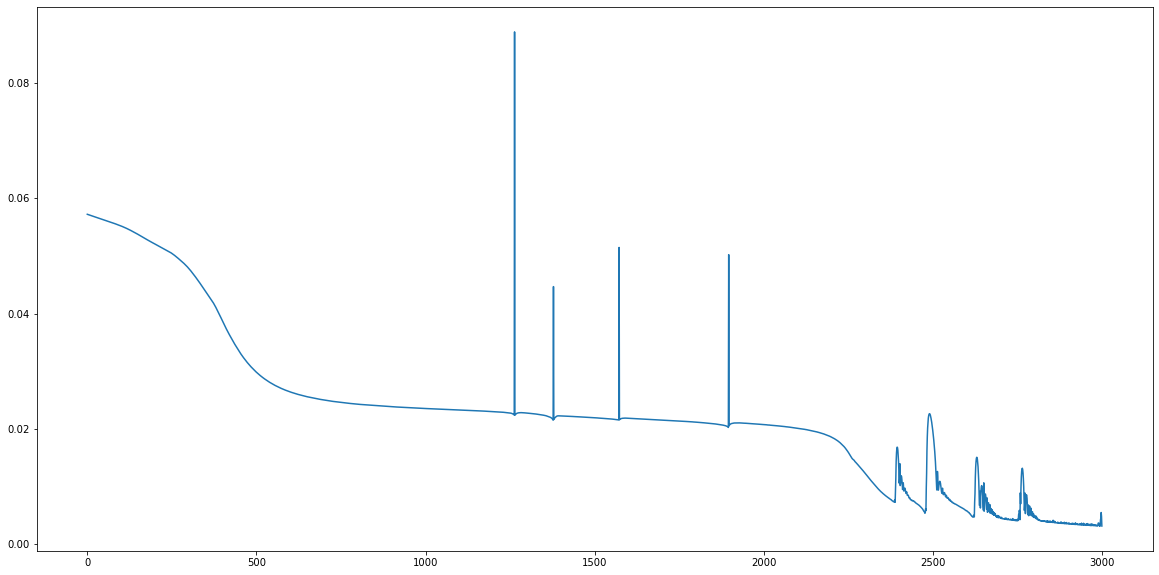

In [112]:
fig = plt.figure(figsize=(20,10))
fig = plt.plot(train_loss_avg) 
#plt.savefig("loss.png")
plt.show()

(0.0, 0.08407983928918839)

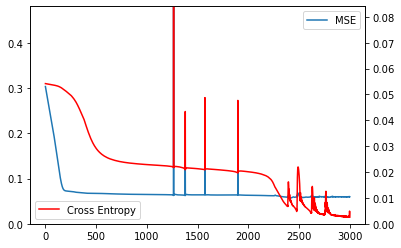

In [113]:
fig, ax = plt.subplots()
ax.plot(mse_avg, label="MSE")
ax2 = ax.twinx()
ax2.plot(ce_avg, color="red", label="Cross Entropy")
ax.legend(loc=1)
ax.set_ylim(0, max(mse_avg))

ax2.legend(loc=3)
ax2.set_ylim(0, max(ce_avg))
   

In [105]:

import sys
from turtle import pos

import meshplot as mp
from vec3 import Vec3
    
grafo = G

posiciones = nx.get_node_attributes( grafo, 'posicion')

li = posiciones[0].toList()
li = [x.cpu().detach() for x in li]
print(li)
posiciones.update((x, y.toList()) for x, y in posiciones.items())
print(posiciones[0])

posiciones.update((x, [a.cpu().detach() for a in y]) for x, y in posiciones.items())
print(posiciones)
p = mp.plot( np.array([ np.array(posiciones[node]) for node in grafo.nodes]), return_plot=True, shading={'point_size':4})



for arista in grafo.edges:
    #print("ariste", grafo.nodes[arista[0]]['posicion'].toList())
    arista0 = grafo.nodes[arista[0]]['posicion'].toList()
    arista1 = grafo.nodes[arista[1]]['posicion'].toList()
    print("ariste", arista0)
    arista_0 = [x.cpu().detach() for x in arista0]
    print("ariste", arista_0)
    arista_1 = [x.cpu().detach() for x in arista1]
    p.add_lines( arista_0, arista_1)


[tensor(-0.0724), tensor(0.8101), tensor(0.2720)]
[tensor(-0.0724, device='cuda:0', grad_fn=<SelectBackward0>), tensor(0.8101, device='cuda:0', grad_fn=<SelectBackward0>), tensor(0.2720, device='cuda:0', grad_fn=<SelectBackward0>)]
{0: [tensor(-0.0724), tensor(0.8101), tensor(0.2720)], 1: [tensor(0.2202), tensor(0.6227), tensor(0.3463)], 2: [tensor(0.2441), tensor(0.6808), tensor(0.3312)], 3: [tensor(0.2582), tensor(0.6814), tensor(0.3336)], 4: [tensor(0.2752), tensor(0.6710), tensor(0.3422)], 5: [tensor(0.2937), tensor(0.6592), tensor(0.3532)], 6: [tensor(0.3105), tensor(0.6468), tensor(0.3627)], 7: [tensor(0.3245), tensor(0.6357), tensor(0.3707)], 8: [tensor(0.3366), tensor(0.6269), tensor(0.3772)], 9: [tensor(0.3480), tensor(0.6200), tensor(0.3834)], 10: [tensor(0.3596), tensor(0.6144), tensor(0.3899)], 11: [tensor(0.3726), tensor(0.6101), tensor(0.3967)], 12: [tensor(0.3874), tensor(0.6067), tensor(0.4046)], 13: [tensor(0.4061), tensor(0.6044), tensor(0.4138)], 14: [tensor(0.4311),

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3283734…

ariste [tensor(-0.0724, device='cuda:0', grad_fn=<SelectBackward0>), tensor(0.8101, device='cuda:0', grad_fn=<SelectBackward0>), tensor(0.2720, device='cuda:0', grad_fn=<SelectBackward0>)]
ariste [tensor(-0.0724), tensor(0.8101), tensor(0.2720)]


AttributeError: 'list' object has no attribute 'shape'